In [24]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.graph_objects as go
from torch.distributions import Dirichlet
from torch.distributions.kl import _kl_dirichlet_dirichlet
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
# create synthetic data set
# analogous to original synthetic dataset. See:
# https://github.com/KaosEngineer/PriorNetworks-OLD/blob/master/prior_networks/dirichlet/dirichlet_prior_network_synth.py#L73


## Synthetic Dataset

Create a synthetic dataset of 500 points which corresponds to 3 gaussians.

In [17]:

num_points = 500
# ensure num_points is divisible by 3
num_points = 3 * (num_points // 3)
mixture_proportions = [1 / 3.0, 1 / 3.0, 1 / 3.0]
scale = 10.0
mu = [
    scale * np.asarray([0, 1.0], dtype=np.float32),
    scale * np.asarray([-np.sqrt(3) / 2, -1. / 2], dtype=np.float32),
    scale * np.asarray([np.sqrt(3) / 2, -1. / 2], dtype=np.float32)
]
diag_cov = 2 * np.identity(2)

In [18]:
# create dataset

samples, labels = [], []
for i in range(len(mu)):
    num_class_samples = int(num_points*mixture_proportions[i])
    class_samples = np.random.multivariate_normal(
        mean=mu[i],
        cov=diag_cov,
        size=num_class_samples)
    samples.append(class_samples)
    class_labels = np.full(
        shape=num_class_samples,
        fill_value=i)
    labels.append(class_labels)
samples = np.concatenate(samples)
labels = np.concatenate(labels)

In [19]:
# shuffle dataset

shuffle_idx = np.random.choice(
    np.arange(num_points),
    size=num_points,
    replace=False)
samples = samples[shuffle_idx, :]
labels = labels[shuffle_idx]

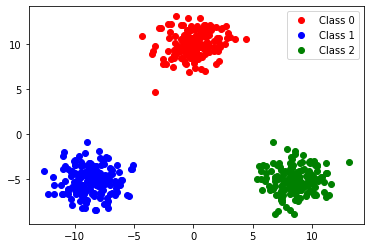

In [20]:
plt.plot(samples[labels==0][:,0], samples[labels==0][:,1], 'ro', label='Class 0')
plt.plot(samples[labels==1][:,0], samples[labels==1][:,1], 'bo', label='Class 1')
plt.plot(samples[labels==2][:,0], samples[labels==2][:,1], 'go', label='Class 2')
plt.legend()
plt.show()

In [25]:
lr_skl = LogisticRegression(C=100000, fit_intercept=True, solver='liblinear', multi_class='ovr')
lr_skl.fit(samples, labels)

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
lr_skl.predict_proba(samples)

array([[9.99984649e-01, 1.53407829e-05, 1.01026678e-08],
       [9.99994297e-01, 2.97364903e-10, 5.70313589e-06],
       [9.99999756e-01, 1.64400014e-07, 7.93898672e-08],
       ...,
       [9.99999910e-01, 9.72099047e-09, 8.04629211e-08],
       [1.29024125e-10, 9.99999999e-01, 1.00729909e-09],
       [9.99996611e-01, 6.29856327e-10, 3.38795631e-06]])

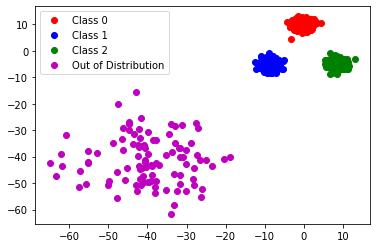

In [35]:
outofdist_samples = np.random.normal(-40, 10, size=(100, 2))
plt.plot(samples[labels==0][:,0], samples[labels==0][:,1], 'ro', label='Class 0')
plt.plot(samples[labels==1][:,0], samples[labels==1][:,1], 'bo', label='Class 1')
plt.plot(samples[labels==2][:,0], samples[labels==2][:,1], 'go', label='Class 2')
plt.plot(outofdist_samples[:,0], outofdist_samples[:,1], 'mo', label='Out of Distribution')

plt.legend()
plt.show()

In [38]:
lr_skl.predict_proba(outofdist_samples)

array([[1.00116329e-70, 1.00000000e+00, 2.32416004e-18],
       [2.64633499e-40, 1.00000000e+00, 2.69008337e-21],
       [1.71421360e-59, 1.00000000e+00, 3.25285455e-38],
       [6.10743612e-66, 9.99999658e-01, 3.42462971e-07],
       [1.15283432e-59, 1.00000000e+00, 1.37969607e-49],
       [1.80141929e-64, 1.00000000e+00, 4.76699311e-27],
       [2.65769690e-70, 9.99940187e-01, 5.98133768e-05],
       [9.44708437e-60, 9.99999981e-01, 1.92413619e-08],
       [3.72032094e-62, 1.00000000e+00, 3.33629250e-25],
       [3.42244524e-55, 9.99999676e-01, 3.23632798e-07],
       [1.27125929e-70, 1.00000000e+00, 1.79478646e-33],
       [3.77774029e-71, 5.96729856e-01, 4.03270144e-01],
       [3.64273484e-62, 1.00000000e+00, 1.90402210e-20],
       [7.22233022e-64, 1.00000000e+00, 1.54106159e-38],
       [6.87612207e-52, 1.00000000e+00, 2.15687011e-14],
       [1.88325162e-61, 1.00000000e+00, 7.28436614e-20],
       [3.79622574e-50, 1.00000000e+00, 1.22478181e-27],
       [1.97782477e-44, 1.00000

In [29]:
#helper to calculate mean entropy
def calc_mean_entropy(preds):
    entropies = []
    for i in range(preds.shape[0]):
        entropies.append(stats.entropy(preds[i]))
    return np.array(entropies).mean()

In [37]:
lr_in_dist_entropy = calc_mean_entropy(lr_skl.predict_proba(samples))
lr_out_dist_entropy = calc_mean_entropy(lr_skl.predict_proba(outofdist_samples))
print(f"Logistic Regression: in distribution entropy = {lr_in_dist_entropy}, out of distribution entropy = {lr_out_dist_entropy}")

Logistic Regression: in distribution entropy = 0.0008392400710570838, out of distribution entropy = 0.05579186421134608


In [42]:
# helper function for checking that no element is NaN or Inf
def assert_no_nan_no_inf(x):
    assert not torch.isnan(x).any()
    assert not torch.isinf(x).any()

# Logistic Regression via Prior Network methodology

We will first train the logistic regression model using the prior network methodology by minimizing the forward KL divergence.

In [48]:
# defines the sharpness of the target Dirichlet distribution
alpha_0 = 100

In [62]:
# convert data from numpy arrays to tensors
samples_tens = torch.Tensor(samples)
labels_tens = torch.Tensor(labels).to(torch.int64)
outofdist_samples_tens = torch.Tensor(outofdist_samples)
samples_aug = torch.cat((samples_tens, outofdist_samples_tens))
samples_aug.shape

torch.Size([598, 2])

In [58]:
# now, we transition towards trying the prior networks approach.
# we will first attempt to train using the left term of Equation 12

# define softened labels
one_hot_labels = F.one_hot(labels_tens).to(torch.float32)
soft_concentrations = one_hot_labels.numpy()
soft_concentrations = np.where(soft_concentrations==1, alpha_0+1, 1)
soft_concentrations = torch.Tensor(soft_concentrations)
soft_concentrations

tensor([[101.,   1.,   1.],
        [101.,   1.,   1.],
        [101.,   1.,   1.],
        ...,
        [101.,   1.,   1.],
        [  1., 101.,   1.],
        [101.,   1.,   1.]])

In [64]:
out_of_dist_concentrations = torch.tensor(
    np.ones(shape=(outofdist_samples.shape[0], 3))).to(torch.float32)
soft_concentrations_aug = torch.cat((soft_concentrations, out_of_dist_concentrations))
soft_concentrations_aug

tensor([[101.,   1.,   1.],
        [101.,   1.,   1.],
        [101.,   1.,   1.],
        ...,
        [  1.,   1.,   1.],
        [  1.,   1.,   1.],
        [  1.,   1.,   1.]])

In [159]:
# define loss function
# first term of equation 12. See
# https://github.com/KaosEngineer/PriorNetworks-OLD/blob/master/prior_networks/dirichlet/dirichlet_prior_network_synth.py#L107
def eqn_twelve(model_outputs, target_concentrations, reverse=True):
    target_dirichlet = Dirichlet(target_concentrations)
    model_dirichlet = Dirichlet(model_outputs)
    if reverse:
        kl_divs = _kl_dirichlet_dirichlet(p=model_dirichlet, q=target_dirichlet)
    else:
        kl_divs = _kl_dirichlet_dirichlet(p=target_dirichlet, q=model_dirichlet)
    #assert_no_nan_no_inf(kl_divs)
    mean_kl = torch.mean(kl_divs)
    return mean_kl

In [160]:
class Toy_Net(torch.nn.Module):
    def __init__(self, n_in, n_out, alpha_0=1. , n_hidden=12):
        super(Toy_Net, self).__init__()
        self.alpha_0 = alpha_0
        self.linear_block = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.LeakyReLU(),
            nn.Linear(n_hidden, n_out),
            #nn.Sigmoid()
        )
    def forward(self, x):
        logits = self.linear_block(x)
        #mean = F.softmax(logits / self.alpha_0, dim=1) #I have doubts about alpha 0..
        alphas = torch.exp(logits) + 1
        #precision = torch.sum(alphas)
        return alphas

In [196]:
# create new network
pn_forward_net = Toy_Net(2,3,50)
optimizer = optim.SGD(pn_forward_net.parameters(), lr=0.001)
num_points = samples.shape[0] + outofdist_samples.shape[0]
num_training_steps = 10000
batch_size = 100

# train only for in distribution
losses, grad_norms = [], []
for step in range(num_training_steps):
    optimizer.zero_grad()   # zero the gradient buffers
    batch_idx = np.random.choice(
        np.arange(num_points),
        size=batch_size,
        replace=False)
    batch_samples = samples_aug[batch_idx]
    batch_concentrations = soft_concentrations_aug[batch_idx]
    pred_labels = pn_forward_net(batch_samples)
    #print(step)
    #print(batch_concentrations)
    #print(pred_labels)
    loss = eqn_twelve(
        model_outputs=pred_labels,
        target_concentrations=batch_concentrations, reverse=True)
    print('Step: {}, Loss: {}'.format(step, loss.item()))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

Step: 0, Loss: 79.56059265136719
Step: 1, Loss: 39.170005798339844
Step: 2, Loss: 19.547197341918945
Step: 3, Loss: 15.513014793395996
Step: 4, Loss: 11.377849578857422
Step: 5, Loss: 8.649410247802734
Step: 6, Loss: 8.322613716125488
Step: 7, Loss: 8.344464302062988
Step: 8, Loss: 5.302006721496582
Step: 9, Loss: 8.127673149108887
Step: 10, Loss: 5.913084030151367
Step: 11, Loss: 5.669795513153076
Step: 12, Loss: 4.802833080291748
Step: 13, Loss: 5.832111835479736
Step: 14, Loss: 4.5858917236328125
Step: 15, Loss: 3.960965633392334
Step: 16, Loss: 5.524700164794922
Step: 17, Loss: 5.371274471282959
Step: 18, Loss: 4.902378559112549
Step: 19, Loss: 7.9687089920043945
Step: 20, Loss: 3.8725767135620117
Step: 21, Loss: 4.2990336418151855
Step: 22, Loss: 4.683825492858887
Step: 23, Loss: 5.334766387939453
Step: 24, Loss: 4.081583023071289
Step: 25, Loss: 5.501862049102783
Step: 26, Loss: 3.8706579208374023
Step: 27, Loss: 3.59405517578125
Step: 28, Loss: 6.105259418487549
Step: 29, Loss: 

Step: 330, Loss: 2.3465704917907715
Step: 331, Loss: 2.7175660133361816
Step: 332, Loss: 2.267307996749878
Step: 333, Loss: 1.9198846817016602
Step: 334, Loss: 2.701603651046753
Step: 335, Loss: 3.6869819164276123
Step: 336, Loss: 3.155782461166382
Step: 337, Loss: 2.129357099533081
Step: 338, Loss: 2.332029104232788
Step: 339, Loss: 3.3910765647888184
Step: 340, Loss: 2.927833318710327
Step: 341, Loss: 2.4146153926849365
Step: 342, Loss: 2.303805351257324
Step: 343, Loss: 3.470374345779419
Step: 344, Loss: 3.281587839126587
Step: 345, Loss: 2.8337273597717285
Step: 346, Loss: 3.822226047515869
Step: 347, Loss: 3.985875129699707
Step: 348, Loss: 2.9050514698028564
Step: 349, Loss: 3.612706184387207
Step: 350, Loss: 4.66693115234375
Step: 351, Loss: 3.4621167182922363
Step: 352, Loss: 3.960984230041504
Step: 353, Loss: 1.565190315246582
Step: 354, Loss: 2.9185080528259277
Step: 355, Loss: 3.5023186206817627
Step: 356, Loss: 2.6161184310913086
Step: 357, Loss: 2.603832960128784
Step: 358

Step: 575, Loss: 2.8714284896850586
Step: 576, Loss: 3.144375801086426
Step: 577, Loss: 2.8558855056762695
Step: 578, Loss: 3.02962589263916
Step: 579, Loss: 2.7111988067626953
Step: 580, Loss: 3.544605016708374
Step: 581, Loss: 2.805647850036621
Step: 582, Loss: 3.625061273574829
Step: 583, Loss: 2.3519246578216553
Step: 584, Loss: 2.8106162548065186
Step: 585, Loss: 3.826385736465454
Step: 586, Loss: 2.747068166732788
Step: 587, Loss: 2.737748384475708
Step: 588, Loss: 3.021620273590088
Step: 589, Loss: 2.857597589492798
Step: 590, Loss: 2.410888433456421
Step: 591, Loss: 3.1261332035064697
Step: 592, Loss: 2.8192319869995117
Step: 593, Loss: 3.2814877033233643
Step: 594, Loss: 3.6196889877319336
Step: 595, Loss: 3.3422985076904297
Step: 596, Loss: 3.8827035427093506
Step: 597, Loss: 3.1368906497955322
Step: 598, Loss: 2.516876220703125
Step: 599, Loss: 2.5987439155578613
Step: 600, Loss: 2.4448604583740234
Step: 601, Loss: 3.442260980606079
Step: 602, Loss: 2.7076339721679688
Step: 

Step: 821, Loss: 2.518526077270508
Step: 822, Loss: 2.4283745288848877
Step: 823, Loss: 2.6620523929595947
Step: 824, Loss: 2.6084659099578857
Step: 825, Loss: 2.116067886352539
Step: 826, Loss: 2.1509921550750732
Step: 827, Loss: 1.6805315017700195
Step: 828, Loss: 2.556443691253662
Step: 829, Loss: 1.9752274751663208
Step: 830, Loss: 2.053713321685791
Step: 831, Loss: 1.9834885597229004
Step: 832, Loss: 2.533468723297119
Step: 833, Loss: 2.1907846927642822
Step: 834, Loss: 3.7568392753601074
Step: 835, Loss: 2.315538167953491
Step: 836, Loss: 3.435647964477539
Step: 837, Loss: 2.57253360748291
Step: 838, Loss: 2.233307123184204
Step: 839, Loss: 2.0187392234802246
Step: 840, Loss: 2.4906928539276123
Step: 841, Loss: 2.1070499420166016
Step: 842, Loss: 3.526657819747925
Step: 843, Loss: 2.3978700637817383
Step: 844, Loss: 2.6503849029541016
Step: 845, Loss: 2.9893527030944824
Step: 846, Loss: 3.7660770416259766
Step: 847, Loss: 3.0499508380889893
Step: 848, Loss: 2.2982871532440186
Ste

Step: 1090, Loss: 1.9710062742233276
Step: 1091, Loss: 2.010422706604004
Step: 1092, Loss: 2.866560935974121
Step: 1093, Loss: 2.742462396621704
Step: 1094, Loss: 2.6979596614837646
Step: 1095, Loss: 1.7418626546859741
Step: 1096, Loss: 2.7073330879211426
Step: 1097, Loss: 1.7186460494995117
Step: 1098, Loss: 1.1222505569458008
Step: 1099, Loss: 2.348005533218384
Step: 1100, Loss: 2.8864498138427734
Step: 1101, Loss: 1.960069179534912
Step: 1102, Loss: 1.2699127197265625
Step: 1103, Loss: 2.84017276763916
Step: 1104, Loss: 2.2879579067230225
Step: 1105, Loss: 1.4226198196411133
Step: 1106, Loss: 1.4155220985412598
Step: 1107, Loss: 2.815871238708496
Step: 1108, Loss: 1.6173988580703735
Step: 1109, Loss: 1.9987930059432983
Step: 1110, Loss: 1.6098239421844482
Step: 1111, Loss: 2.112689256668091
Step: 1112, Loss: 1.7003941535949707
Step: 1113, Loss: 2.9326860904693604
Step: 1114, Loss: 1.9037120342254639
Step: 1115, Loss: 2.8356714248657227
Step: 1116, Loss: 1.292268991470337
Step: 1117,

Step: 1438, Loss: 1.2306326627731323
Step: 1439, Loss: 1.2895926237106323
Step: 1440, Loss: 1.3006837368011475
Step: 1441, Loss: 1.5853636264801025
Step: 1442, Loss: 1.6442991495132446
Step: 1443, Loss: 1.3153778314590454
Step: 1444, Loss: 1.3893110752105713
Step: 1445, Loss: 1.8113933801651
Step: 1446, Loss: 1.8393635749816895
Step: 1447, Loss: 1.2571865320205688
Step: 1448, Loss: 1.5117188692092896
Step: 1449, Loss: 1.9884934425354004
Step: 1450, Loss: 1.34443998336792
Step: 1451, Loss: 1.015184760093689
Step: 1452, Loss: 1.3338630199432373
Step: 1453, Loss: 1.4462071657180786
Step: 1454, Loss: 1.9441380500793457
Step: 1455, Loss: 1.0862691402435303
Step: 1456, Loss: 1.855268955230713
Step: 1457, Loss: 1.4528415203094482
Step: 1458, Loss: 1.3527718782424927
Step: 1459, Loss: 1.7709660530090332
Step: 1460, Loss: 1.4065537452697754
Step: 1461, Loss: 1.551262617111206
Step: 1462, Loss: 1.201374888420105
Step: 1463, Loss: 1.4301222562789917
Step: 1464, Loss: 1.4992091655731201
Step: 1465

Step: 1711, Loss: 0.865265429019928
Step: 1712, Loss: 0.990862250328064
Step: 1713, Loss: 1.226518988609314
Step: 1714, Loss: 0.9561325311660767
Step: 1715, Loss: 1.106407642364502
Step: 1716, Loss: 1.1438714265823364
Step: 1717, Loss: 0.8310474157333374
Step: 1718, Loss: 0.9526422619819641
Step: 1719, Loss: 1.2178359031677246
Step: 1720, Loss: 0.9765366315841675
Step: 1721, Loss: 0.9827356934547424
Step: 1722, Loss: 1.2448521852493286
Step: 1723, Loss: 0.9105675220489502
Step: 1724, Loss: 1.003092885017395
Step: 1725, Loss: 0.7782219052314758
Step: 1726, Loss: 0.9285269379615784
Step: 1727, Loss: 0.9604125022888184
Step: 1728, Loss: 0.8581279516220093
Step: 1729, Loss: 0.9309982061386108
Step: 1730, Loss: 0.8513162136077881
Step: 1731, Loss: 1.382826805114746
Step: 1732, Loss: 1.1889314651489258
Step: 1733, Loss: 1.0107295513153076
Step: 1734, Loss: 0.7968446612358093
Step: 1735, Loss: 0.9950618147850037
Step: 1736, Loss: 0.7071040868759155
Step: 1737, Loss: 1.1493560075759888
Step: 1

Step: 1938, Loss: 0.6627187132835388
Step: 1939, Loss: 0.6288439631462097
Step: 1940, Loss: 0.8200517296791077
Step: 1941, Loss: 0.7887253761291504
Step: 1942, Loss: 0.7023799419403076
Step: 1943, Loss: 0.6209419369697571
Step: 1944, Loss: 0.5687026381492615
Step: 1945, Loss: 0.6414065361022949
Step: 1946, Loss: 0.7646075487136841
Step: 1947, Loss: 0.8530961871147156
Step: 1948, Loss: 0.7858007550239563
Step: 1949, Loss: 0.6109997630119324
Step: 1950, Loss: 0.8691154718399048
Step: 1951, Loss: 0.5779449343681335
Step: 1952, Loss: 0.8875198364257812
Step: 1953, Loss: 0.8631333708763123
Step: 1954, Loss: 0.6783728003501892
Step: 1955, Loss: 0.6924713850021362
Step: 1956, Loss: 0.6599630117416382
Step: 1957, Loss: 0.6785397529602051
Step: 1958, Loss: 0.7060266137123108
Step: 1959, Loss: 0.6253893375396729
Step: 1960, Loss: 0.7048994302749634
Step: 1961, Loss: 0.8181843757629395
Step: 1962, Loss: 0.5162655115127563
Step: 1963, Loss: 0.724854052066803
Step: 1964, Loss: 0.8074485063552856
St

Step: 2164, Loss: 0.6795522570610046
Step: 2165, Loss: 0.7386894822120667
Step: 2166, Loss: 0.42968040704727173
Step: 2167, Loss: 0.6226527690887451
Step: 2168, Loss: 0.43017104268074036
Step: 2169, Loss: 0.44422122836112976
Step: 2170, Loss: 0.5986482501029968
Step: 2171, Loss: 0.4325239658355713
Step: 2172, Loss: 0.4849841594696045
Step: 2173, Loss: 0.3747099041938782
Step: 2174, Loss: 0.417292058467865
Step: 2175, Loss: 0.38685718178749084
Step: 2176, Loss: 0.46713268756866455
Step: 2177, Loss: 0.4332515597343445
Step: 2178, Loss: 0.48765918612480164
Step: 2179, Loss: 0.4348110258579254
Step: 2180, Loss: 0.41633856296539307
Step: 2181, Loss: 0.5233637690544128
Step: 2182, Loss: 0.35869190096855164
Step: 2183, Loss: 0.4829893112182617
Step: 2184, Loss: 0.39117181301116943
Step: 2185, Loss: 0.5634511113166809
Step: 2186, Loss: 0.5014421939849854
Step: 2187, Loss: 0.5137690901756287
Step: 2188, Loss: 0.5847943425178528
Step: 2189, Loss: 0.471733957529068
Step: 2190, Loss: 0.33618527650

Step: 2463, Loss: 0.28737831115722656
Step: 2464, Loss: 0.3803100883960724
Step: 2465, Loss: 0.43353477120399475
Step: 2466, Loss: 0.3799668252468109
Step: 2467, Loss: 0.271781325340271
Step: 2468, Loss: 0.36781513690948486
Step: 2469, Loss: 0.32890212535858154
Step: 2470, Loss: 0.4174939692020416
Step: 2471, Loss: 0.317773699760437
Step: 2472, Loss: 0.4101708233356476
Step: 2473, Loss: 0.40660250186920166
Step: 2474, Loss: 0.2578439712524414
Step: 2475, Loss: 0.5272128582000732
Step: 2476, Loss: 0.35695868730545044
Step: 2477, Loss: 0.3977717161178589
Step: 2478, Loss: 0.3626728355884552
Step: 2479, Loss: 0.40451180934906006
Step: 2480, Loss: 0.400712788105011
Step: 2481, Loss: 0.26400095224380493
Step: 2482, Loss: 0.3355576992034912
Step: 2483, Loss: 0.3744106590747833
Step: 2484, Loss: 0.40399375557899475
Step: 2485, Loss: 0.42293938994407654
Step: 2486, Loss: 0.40940558910369873
Step: 2487, Loss: 0.3476904034614563
Step: 2488, Loss: 0.38620051741600037
Step: 2489, Loss: 0.432954102

Step: 2758, Loss: 0.2664377987384796
Step: 2759, Loss: 0.2898973524570465
Step: 2760, Loss: 0.4025711715221405
Step: 2761, Loss: 0.3174588084220886
Step: 2762, Loss: 0.25711220502853394
Step: 2763, Loss: 0.2560168504714966
Step: 2764, Loss: 0.48207247257232666
Step: 2765, Loss: 0.4142017662525177
Step: 2766, Loss: 0.26678478717803955
Step: 2767, Loss: 0.3527616858482361
Step: 2768, Loss: 0.2234008014202118
Step: 2769, Loss: 0.3637532889842987
Step: 2770, Loss: 0.3229061961174011
Step: 2771, Loss: 0.3034728169441223
Step: 2772, Loss: 0.31065884232521057
Step: 2773, Loss: 0.26547104120254517
Step: 2774, Loss: 0.3855260908603668
Step: 2775, Loss: 0.32732653617858887
Step: 2776, Loss: 0.2810755670070648
Step: 2777, Loss: 0.24290777742862701
Step: 2778, Loss: 0.4265501797199249
Step: 2779, Loss: 0.40862542390823364
Step: 2780, Loss: 0.28917044401168823
Step: 2781, Loss: 0.44179001450538635
Step: 2782, Loss: 0.2381681203842163
Step: 2783, Loss: 0.2173297107219696
Step: 2784, Loss: 0.33953928

Step: 3028, Loss: 0.2536740303039551
Step: 3029, Loss: 0.21162645518779755
Step: 3030, Loss: 0.19246633350849152
Step: 3031, Loss: 0.2885184586048126
Step: 3032, Loss: 0.33032774925231934
Step: 3033, Loss: 0.1976449191570282
Step: 3034, Loss: 0.23796062171459198
Step: 3035, Loss: 0.22862312197685242
Step: 3036, Loss: 0.237452894449234
Step: 3037, Loss: 0.4034397006034851
Step: 3038, Loss: 0.19609513878822327
Step: 3039, Loss: 0.282257080078125
Step: 3040, Loss: 0.3821219503879547
Step: 3041, Loss: 0.2404993176460266
Step: 3042, Loss: 0.20398488640785217
Step: 3043, Loss: 0.23267360031604767
Step: 3044, Loss: 0.2819213569164276
Step: 3045, Loss: 0.22851499915122986
Step: 3046, Loss: 0.3197694718837738
Step: 3047, Loss: 0.26288074254989624
Step: 3048, Loss: 0.2943626940250397
Step: 3049, Loss: 0.19631710648536682
Step: 3050, Loss: 0.348649263381958
Step: 3051, Loss: 0.23434044420719147
Step: 3052, Loss: 0.2420918494462967
Step: 3053, Loss: 0.30934447050094604
Step: 3054, Loss: 0.24099561

Step: 3305, Loss: 0.35479986667633057
Step: 3306, Loss: 0.2194833904504776
Step: 3307, Loss: 0.29524096846580505
Step: 3308, Loss: 0.22247983515262604
Step: 3309, Loss: 0.22386668622493744
Step: 3310, Loss: 0.3489624857902527
Step: 3311, Loss: 0.21748510003089905
Step: 3312, Loss: 0.19256700575351715
Step: 3313, Loss: 0.24959783256053925
Step: 3314, Loss: 0.2550167143344879
Step: 3315, Loss: 0.308905690908432
Step: 3316, Loss: 0.26796793937683105
Step: 3317, Loss: 0.28856605291366577
Step: 3318, Loss: 0.3455272316932678
Step: 3319, Loss: 0.3047237992286682
Step: 3320, Loss: 0.31979885697364807
Step: 3321, Loss: 0.23527458310127258
Step: 3322, Loss: 0.21382836997509003
Step: 3323, Loss: 0.21240051090717316
Step: 3324, Loss: 0.2614600658416748
Step: 3325, Loss: 0.17767345905303955
Step: 3326, Loss: 0.21165883541107178
Step: 3327, Loss: 0.28364497423171997
Step: 3328, Loss: 0.2585165202617645
Step: 3329, Loss: 0.23539245128631592
Step: 3330, Loss: 0.331452339887619
Step: 3331, Loss: 0.287

Step: 3573, Loss: 0.24069814383983612
Step: 3574, Loss: 0.2519042491912842
Step: 3575, Loss: 0.17790652811527252
Step: 3576, Loss: 0.27663230895996094
Step: 3577, Loss: 0.18393459916114807
Step: 3578, Loss: 0.2754266560077667
Step: 3579, Loss: 0.19014793634414673
Step: 3580, Loss: 0.1934400349855423
Step: 3581, Loss: 0.2888825833797455
Step: 3582, Loss: 0.25347819924354553
Step: 3583, Loss: 0.2720004916191101
Step: 3584, Loss: 0.25782424211502075
Step: 3585, Loss: 0.3004549443721771
Step: 3586, Loss: 0.21470016241073608
Step: 3587, Loss: 0.2811567187309265
Step: 3588, Loss: 0.1608777791261673
Step: 3589, Loss: 0.28972575068473816
Step: 3590, Loss: 0.25702208280563354
Step: 3591, Loss: 0.20390985906124115
Step: 3592, Loss: 0.2332577109336853
Step: 3593, Loss: 0.14797188341617584
Step: 3594, Loss: 0.24412328004837036
Step: 3595, Loss: 0.27994003891944885
Step: 3596, Loss: 0.32992613315582275
Step: 3597, Loss: 0.28289279341697693
Step: 3598, Loss: 0.3220902979373932
Step: 3599, Loss: 0.22

Step: 3825, Loss: 0.25097352266311646
Step: 3826, Loss: 0.19479084014892578
Step: 3827, Loss: 0.19044990837574005
Step: 3828, Loss: 0.24978581070899963
Step: 3829, Loss: 0.2860572040081024
Step: 3830, Loss: 0.2109539657831192
Step: 3831, Loss: 0.19332776963710785
Step: 3832, Loss: 0.14196407794952393
Step: 3833, Loss: 0.25899580121040344
Step: 3834, Loss: 0.23045696318149567
Step: 3835, Loss: 0.25920403003692627
Step: 3836, Loss: 0.19053056836128235
Step: 3837, Loss: 0.2211024910211563
Step: 3838, Loss: 0.26867541670799255
Step: 3839, Loss: 0.15590721368789673
Step: 3840, Loss: 0.20016059279441833
Step: 3841, Loss: 0.17530187964439392
Step: 3842, Loss: 0.2721365690231323
Step: 3843, Loss: 0.26014894247055054
Step: 3844, Loss: 0.2099311798810959
Step: 3845, Loss: 0.3367424011230469
Step: 3846, Loss: 0.24039289355278015
Step: 3847, Loss: 0.24904891848564148
Step: 3848, Loss: 0.2734629809856415
Step: 3849, Loss: 0.16964980959892273
Step: 3850, Loss: 0.14882677793502808
Step: 3851, Loss: 0

Step: 4053, Loss: 0.23017288744449615
Step: 4054, Loss: 0.20540021359920502
Step: 4055, Loss: 0.24547651410102844
Step: 4056, Loss: 0.12938299775123596
Step: 4057, Loss: 0.21077960729599
Step: 4058, Loss: 0.17942014336585999
Step: 4059, Loss: 0.3328807055950165
Step: 4060, Loss: 0.17310896515846252
Step: 4061, Loss: 0.20260463654994965
Step: 4062, Loss: 0.20310886204242706
Step: 4063, Loss: 0.3495446443557739
Step: 4064, Loss: 0.26130354404449463
Step: 4065, Loss: 0.22213710844516754
Step: 4066, Loss: 0.14759506285190582
Step: 4067, Loss: 0.1921374350786209
Step: 4068, Loss: 0.23332375288009644
Step: 4069, Loss: 0.23293285071849823
Step: 4070, Loss: 0.2115289568901062
Step: 4071, Loss: 0.1744356006383896
Step: 4072, Loss: 0.1637994647026062
Step: 4073, Loss: 0.18248985707759857
Step: 4074, Loss: 0.3271356225013733
Step: 4075, Loss: 0.14819927513599396
Step: 4076, Loss: 0.1631537228822708
Step: 4077, Loss: 0.22999988496303558
Step: 4078, Loss: 0.24955151975154877
Step: 4079, Loss: 0.308

Step: 4282, Loss: 0.30756881833076477
Step: 4283, Loss: 0.2104281634092331
Step: 4284, Loss: 0.23435142636299133
Step: 4285, Loss: 0.16759027540683746
Step: 4286, Loss: 0.21361827850341797
Step: 4287, Loss: 0.17333760857582092
Step: 4288, Loss: 0.19140592217445374
Step: 4289, Loss: 0.18191932141780853
Step: 4290, Loss: 0.143706277012825
Step: 4291, Loss: 0.21700939536094666
Step: 4292, Loss: 0.2206646203994751
Step: 4293, Loss: 0.250062495470047
Step: 4294, Loss: 0.2372593879699707
Step: 4295, Loss: 0.2473800778388977
Step: 4296, Loss: 0.23941607773303986
Step: 4297, Loss: 0.251427561044693
Step: 4298, Loss: 0.1525232344865799
Step: 4299, Loss: 0.19494123756885529
Step: 4300, Loss: 0.2709331512451172
Step: 4301, Loss: 0.30002596974372864
Step: 4302, Loss: 0.17287735641002655
Step: 4303, Loss: 0.28619420528411865
Step: 4304, Loss: 0.2955881953239441
Step: 4305, Loss: 0.19885845482349396
Step: 4306, Loss: 0.28945422172546387
Step: 4307, Loss: 0.27031123638153076
Step: 4308, Loss: 0.22974

Step: 4602, Loss: 0.23728513717651367
Step: 4603, Loss: 0.212623730301857
Step: 4604, Loss: 0.2388344705104828
Step: 4605, Loss: 0.2203465700149536
Step: 4606, Loss: 0.19200628995895386
Step: 4607, Loss: 0.1831171065568924
Step: 4608, Loss: 0.23220565915107727
Step: 4609, Loss: 0.17369665205478668
Step: 4610, Loss: 0.23777520656585693
Step: 4611, Loss: 0.1826949268579483
Step: 4612, Loss: 0.23452554643154144
Step: 4613, Loss: 0.20300716161727905
Step: 4614, Loss: 0.18000268936157227
Step: 4615, Loss: 0.18539632856845856
Step: 4616, Loss: 0.2820144593715668
Step: 4617, Loss: 0.19808019697666168
Step: 4618, Loss: 0.21371527016162872
Step: 4619, Loss: 0.14342685043811798
Step: 4620, Loss: 0.20876863598823547
Step: 4621, Loss: 0.22717544436454773
Step: 4622, Loss: 0.17082931101322174
Step: 4623, Loss: 0.23139585554599762
Step: 4624, Loss: 0.2066439986228943
Step: 4625, Loss: 0.2871488630771637
Step: 4626, Loss: 0.31341826915740967
Step: 4627, Loss: 0.29543235898017883
Step: 4628, Loss: 0.1

Step: 4842, Loss: 0.25714728236198425
Step: 4843, Loss: 0.1375160813331604
Step: 4844, Loss: 0.27251923084259033
Step: 4845, Loss: 0.16064664721488953
Step: 4846, Loss: 0.17890167236328125
Step: 4847, Loss: 0.22647157311439514
Step: 4848, Loss: 0.2230912148952484
Step: 4849, Loss: 0.16809554398059845
Step: 4850, Loss: 0.23699240386486053
Step: 4851, Loss: 0.19577324390411377
Step: 4852, Loss: 0.17642252147197723
Step: 4853, Loss: 0.17431169748306274
Step: 4854, Loss: 0.2520143389701843
Step: 4855, Loss: 0.19555167853832245
Step: 4856, Loss: 0.1448688954114914
Step: 4857, Loss: 0.20739908516407013
Step: 4858, Loss: 0.19164679944515228
Step: 4859, Loss: 0.14103494584560394
Step: 4860, Loss: 0.23931625485420227
Step: 4861, Loss: 0.1554209589958191
Step: 4862, Loss: 0.18695668876171112
Step: 4863, Loss: 0.16073668003082275
Step: 4864, Loss: 0.1860172301530838
Step: 4865, Loss: 0.2356557846069336
Step: 4866, Loss: 0.14107897877693176
Step: 4867, Loss: 0.13571178913116455
Step: 4868, Loss: 0

Step: 5135, Loss: 0.1872057020664215
Step: 5136, Loss: 0.20298290252685547
Step: 5137, Loss: 0.0999872088432312
Step: 5138, Loss: 0.20148281753063202
Step: 5139, Loss: 0.12340477108955383
Step: 5140, Loss: 0.24019300937652588
Step: 5141, Loss: 0.21023738384246826
Step: 5142, Loss: 0.18857671320438385
Step: 5143, Loss: 0.1880711019039154
Step: 5144, Loss: 0.21942874789237976
Step: 5145, Loss: 0.19144655764102936
Step: 5146, Loss: 0.2339583784341812
Step: 5147, Loss: 0.2288372963666916
Step: 5148, Loss: 0.1539968103170395
Step: 5149, Loss: 0.1730005294084549
Step: 5150, Loss: 0.18356724083423615
Step: 5151, Loss: 0.167459636926651
Step: 5152, Loss: 0.18025311827659607
Step: 5153, Loss: 0.22380292415618896
Step: 5154, Loss: 0.13564589619636536
Step: 5155, Loss: 0.18253982067108154
Step: 5156, Loss: 0.16196809709072113
Step: 5157, Loss: 0.15377101302146912
Step: 5158, Loss: 0.22978715598583221
Step: 5159, Loss: 0.25178471207618713
Step: 5160, Loss: 0.15158924460411072
Step: 5161, Loss: 0.1

Step: 5360, Loss: 0.19970190525054932
Step: 5361, Loss: 0.1560831516981125
Step: 5362, Loss: 0.2991866171360016
Step: 5363, Loss: 0.1706927865743637
Step: 5364, Loss: 0.256815105676651
Step: 5365, Loss: 0.12896226346492767
Step: 5366, Loss: 0.18175038695335388
Step: 5367, Loss: 0.15720173716545105
Step: 5368, Loss: 0.15508396923542023
Step: 5369, Loss: 0.18924053013324738
Step: 5370, Loss: 0.15147919952869415
Step: 5371, Loss: 0.15436583757400513
Step: 5372, Loss: 0.22320836782455444
Step: 5373, Loss: 0.13720214366912842
Step: 5374, Loss: 0.33686232566833496
Step: 5375, Loss: 0.19767743349075317
Step: 5376, Loss: 0.2690827250480652
Step: 5377, Loss: 0.11391826719045639
Step: 5378, Loss: 0.15001539885997772
Step: 5379, Loss: 0.19687028229236603
Step: 5380, Loss: 0.22867107391357422
Step: 5381, Loss: 0.19712477922439575
Step: 5382, Loss: 0.17749696969985962
Step: 5383, Loss: 0.17301858961582184
Step: 5384, Loss: 0.1636182963848114
Step: 5385, Loss: 0.17450852692127228
Step: 5386, Loss: 0

Step: 5664, Loss: 0.11683495342731476
Step: 5665, Loss: 0.22546541690826416
Step: 5666, Loss: 0.2149822860956192
Step: 5667, Loss: 0.17817072570323944
Step: 5668, Loss: 0.1564205139875412
Step: 5669, Loss: 0.19138340651988983
Step: 5670, Loss: 0.18945303559303284
Step: 5671, Loss: 0.13298280537128448
Step: 5672, Loss: 0.20935435593128204
Step: 5673, Loss: 0.1473352164030075
Step: 5674, Loss: 0.1352984458208084
Step: 5675, Loss: 0.17599628865718842
Step: 5676, Loss: 0.17165987193584442
Step: 5677, Loss: 0.20946024358272552
Step: 5678, Loss: 0.17715591192245483
Step: 5679, Loss: 0.1906096637248993
Step: 5680, Loss: 0.18939292430877686
Step: 5681, Loss: 0.2453017681837082
Step: 5682, Loss: 0.2337517887353897
Step: 5683, Loss: 0.18455909192562103
Step: 5684, Loss: 0.19653944671154022
Step: 5685, Loss: 0.20292732119560242
Step: 5686, Loss: 0.24619869887828827
Step: 5687, Loss: 0.1902991235256195
Step: 5688, Loss: 0.16169473528862
Step: 5689, Loss: 0.1938151866197586
Step: 5690, Loss: 0.1514

Step: 5968, Loss: 0.14071890711784363
Step: 5969, Loss: 0.12848655879497528
Step: 5970, Loss: 0.27389809489250183
Step: 5971, Loss: 0.1866609901189804
Step: 5972, Loss: 0.16694238781929016
Step: 5973, Loss: 0.19051708281040192
Step: 5974, Loss: 0.1508316546678543
Step: 5975, Loss: 0.17735345661640167
Step: 5976, Loss: 0.2415502667427063
Step: 5977, Loss: 0.16797390580177307
Step: 5978, Loss: 0.2648763656616211
Step: 5979, Loss: 0.12282142788171768
Step: 5980, Loss: 0.18120960891246796
Step: 5981, Loss: 0.2252119779586792
Step: 5982, Loss: 0.21500790119171143
Step: 5983, Loss: 0.14845016598701477
Step: 5984, Loss: 0.11679136008024216
Step: 5985, Loss: 0.17930927872657776
Step: 5986, Loss: 0.158942312002182
Step: 5987, Loss: 0.17018824815750122
Step: 5988, Loss: 0.13268353044986725
Step: 5989, Loss: 0.20305438339710236
Step: 5990, Loss: 0.20226934552192688
Step: 5991, Loss: 0.12431342899799347
Step: 5992, Loss: 0.14059746265411377
Step: 5993, Loss: 0.21926341950893402
Step: 5994, Loss: 0

Step: 6260, Loss: 0.1892828494310379
Step: 6261, Loss: 0.18752284348011017
Step: 6262, Loss: 0.15036626160144806
Step: 6263, Loss: 0.22257640957832336
Step: 6264, Loss: 0.17722459137439728
Step: 6265, Loss: 0.24409225583076477
Step: 6266, Loss: 0.19620481133460999
Step: 6267, Loss: 0.18662643432617188
Step: 6268, Loss: 0.19367989897727966
Step: 6269, Loss: 0.20125961303710938
Step: 6270, Loss: 0.16401833295822144
Step: 6271, Loss: 0.18730686604976654
Step: 6272, Loss: 0.20750871300697327
Step: 6273, Loss: 0.14097443222999573
Step: 6274, Loss: 0.2363194227218628
Step: 6275, Loss: 0.1343546360731125
Step: 6276, Loss: 0.2116663008928299
Step: 6277, Loss: 0.20892676711082458
Step: 6278, Loss: 0.129630446434021
Step: 6279, Loss: 0.1593213826417923
Step: 6280, Loss: 0.17808082699775696
Step: 6281, Loss: 0.15619918704032898
Step: 6282, Loss: 0.2113753706216812
Step: 6283, Loss: 0.19703353941440582
Step: 6284, Loss: 0.18869391083717346
Step: 6285, Loss: 0.17435406148433685
Step: 6286, Loss: 0.

Step: 6544, Loss: 0.1510738879442215
Step: 6545, Loss: 0.26714661717414856
Step: 6546, Loss: 0.1692631095647812
Step: 6547, Loss: 0.14756885170936584
Step: 6548, Loss: 0.22446857392787933
Step: 6549, Loss: 0.11780085414648056
Step: 6550, Loss: 0.14512397348880768
Step: 6551, Loss: 0.22352179884910583
Step: 6552, Loss: 0.2730468213558197
Step: 6553, Loss: 0.19723498821258545
Step: 6554, Loss: 0.1347704827785492
Step: 6555, Loss: 0.1424463987350464
Step: 6556, Loss: 0.11611992865800858
Step: 6557, Loss: 0.22060999274253845
Step: 6558, Loss: 0.20489509403705597
Step: 6559, Loss: 0.2349434643983841
Step: 6560, Loss: 0.25138333439826965
Step: 6561, Loss: 0.17963570356369019
Step: 6562, Loss: 0.14567503333091736
Step: 6563, Loss: 0.13118866086006165
Step: 6564, Loss: 0.1461605280637741
Step: 6565, Loss: 0.16159866750240326
Step: 6566, Loss: 0.14735880494117737
Step: 6567, Loss: 0.17580640316009521
Step: 6568, Loss: 0.24539189040660858
Step: 6569, Loss: 0.1048612967133522
Step: 6570, Loss: 0.

Step: 6790, Loss: 0.13945524394512177
Step: 6791, Loss: 0.11609012633562088
Step: 6792, Loss: 0.15331310033798218
Step: 6793, Loss: 0.17910850048065186
Step: 6794, Loss: 0.1965695172548294
Step: 6795, Loss: 0.1490262746810913
Step: 6796, Loss: 0.18545961380004883
Step: 6797, Loss: 0.18987566232681274
Step: 6798, Loss: 0.11628153920173645
Step: 6799, Loss: 0.1796431541442871
Step: 6800, Loss: 0.15438009798526764
Step: 6801, Loss: 0.22712400555610657
Step: 6802, Loss: 0.2008732259273529
Step: 6803, Loss: 0.15988115966320038
Step: 6804, Loss: 0.09239210933446884
Step: 6805, Loss: 0.20569485425949097
Step: 6806, Loss: 0.14476008713245392
Step: 6807, Loss: 0.12550286948680878
Step: 6808, Loss: 0.21266275644302368
Step: 6809, Loss: 0.1049094870686531
Step: 6810, Loss: 0.17220407724380493
Step: 6811, Loss: 0.18432535231113434
Step: 6812, Loss: 0.15483425557613373
Step: 6813, Loss: 0.18231992423534393
Step: 6814, Loss: 0.1377197504043579
Step: 6815, Loss: 0.11954305320978165
Step: 6816, Loss: 

Step: 7141, Loss: 0.15321758389472961
Step: 7142, Loss: 0.19605009257793427
Step: 7143, Loss: 0.1917673647403717
Step: 7144, Loss: 0.21374540030956268
Step: 7145, Loss: 0.18536807596683502
Step: 7146, Loss: 0.20630843937397003
Step: 7147, Loss: 0.15149405598640442
Step: 7148, Loss: 0.15419365465641022
Step: 7149, Loss: 0.1729007512331009
Step: 7150, Loss: 0.1724015176296234
Step: 7151, Loss: 0.15006209909915924
Step: 7152, Loss: 0.187258780002594
Step: 7153, Loss: 0.1611400991678238
Step: 7154, Loss: 0.14029967784881592
Step: 7155, Loss: 0.11811347305774689
Step: 7156, Loss: 0.16514834761619568
Step: 7157, Loss: 0.22779838740825653
Step: 7158, Loss: 0.1287432461977005
Step: 7159, Loss: 0.17675943672657013
Step: 7160, Loss: 0.18708717823028564
Step: 7161, Loss: 0.10542073100805283
Step: 7162, Loss: 0.11590544879436493
Step: 7163, Loss: 0.1306425929069519
Step: 7164, Loss: 0.14804883301258087
Step: 7165, Loss: 0.09953050315380096
Step: 7166, Loss: 0.14088405668735504
Step: 7167, Loss: 0.

Step: 7418, Loss: 0.1845237761735916
Step: 7419, Loss: 0.17191921174526215
Step: 7420, Loss: 0.17926166951656342
Step: 7421, Loss: 0.10659795999526978
Step: 7422, Loss: 0.11349084973335266
Step: 7423, Loss: 0.16235557198524475
Step: 7424, Loss: 0.16832850873470306
Step: 7425, Loss: 0.1607775241136551
Step: 7426, Loss: 0.16058117151260376
Step: 7427, Loss: 0.14803743362426758
Step: 7428, Loss: 0.14325302839279175
Step: 7429, Loss: 0.1230965107679367
Step: 7430, Loss: 0.13754647970199585
Step: 7431, Loss: 0.11347037553787231
Step: 7432, Loss: 0.15041153132915497
Step: 7433, Loss: 0.2081497609615326
Step: 7434, Loss: 0.11707490682601929
Step: 7435, Loss: 0.14169220626354218
Step: 7436, Loss: 0.208231583237648
Step: 7437, Loss: 0.18380150198936462
Step: 7438, Loss: 0.16457967460155487
Step: 7439, Loss: 0.16260793805122375
Step: 7440, Loss: 0.11175523698329926
Step: 7441, Loss: 0.10020975023508072
Step: 7442, Loss: 0.12382956594228745
Step: 7443, Loss: 0.11955591291189194
Step: 7444, Loss: 

Step: 7715, Loss: 0.1667848527431488
Step: 7716, Loss: 0.1243671402335167
Step: 7717, Loss: 0.2046920657157898
Step: 7718, Loss: 0.1420053392648697
Step: 7719, Loss: 0.1175808310508728
Step: 7720, Loss: 0.10635995864868164
Step: 7721, Loss: 0.19874516129493713
Step: 7722, Loss: 0.10890936106443405
Step: 7723, Loss: 0.164158895611763
Step: 7724, Loss: 0.15433388948440552
Step: 7725, Loss: 0.11711634695529938
Step: 7726, Loss: 0.13394007086753845
Step: 7727, Loss: 0.10005613416433334
Step: 7728, Loss: 0.2354302853345871
Step: 7729, Loss: 0.1513911783695221
Step: 7730, Loss: 0.18954269587993622
Step: 7731, Loss: 0.25287914276123047
Step: 7732, Loss: 0.11577729880809784
Step: 7733, Loss: 0.1294059157371521
Step: 7734, Loss: 0.17583249509334564
Step: 7735, Loss: 0.10955775529146194
Step: 7736, Loss: 0.14611157774925232
Step: 7737, Loss: 0.1640341579914093
Step: 7738, Loss: 0.13233564794063568
Step: 7739, Loss: 0.15336281061172485
Step: 7740, Loss: 0.2157493531703949
Step: 7741, Loss: 0.1374

Step: 8048, Loss: 0.13106605410575867
Step: 8049, Loss: 0.12657037377357483
Step: 8050, Loss: 0.18783964216709137
Step: 8051, Loss: 0.16058249771595
Step: 8052, Loss: 0.20621375739574432
Step: 8053, Loss: 0.16596002876758575
Step: 8054, Loss: 0.09991975873708725
Step: 8055, Loss: 0.1265450417995453
Step: 8056, Loss: 0.13906803727149963
Step: 8057, Loss: 0.10635330528020859
Step: 8058, Loss: 0.13748925924301147
Step: 8059, Loss: 0.1270960122346878
Step: 8060, Loss: 0.10567913949489594
Step: 8061, Loss: 0.11234558373689651
Step: 8062, Loss: 0.19877006113529205
Step: 8063, Loss: 0.16603951156139374
Step: 8064, Loss: 0.18996843695640564
Step: 8065, Loss: 0.15388397872447968
Step: 8066, Loss: 0.1670333296060562
Step: 8067, Loss: 0.19158542156219482
Step: 8068, Loss: 0.17111915349960327
Step: 8069, Loss: 0.1548292636871338
Step: 8070, Loss: 0.22058546543121338
Step: 8071, Loss: 0.15551704168319702
Step: 8072, Loss: 0.14064708352088928
Step: 8073, Loss: 0.17077942192554474
Step: 8074, Loss: 0

Step: 8368, Loss: 0.09413542598485947
Step: 8369, Loss: 0.09741534292697906
Step: 8370, Loss: 0.19271190464496613
Step: 8371, Loss: 0.12148206681013107
Step: 8372, Loss: 0.128372922539711
Step: 8373, Loss: 0.09607784450054169
Step: 8374, Loss: 0.15801724791526794
Step: 8375, Loss: 0.19928312301635742
Step: 8376, Loss: 0.14338770508766174
Step: 8377, Loss: 0.13170956075191498
Step: 8378, Loss: 0.1724289059638977
Step: 8379, Loss: 0.1484261453151703
Step: 8380, Loss: 0.13006435334682465
Step: 8381, Loss: 0.11198437958955765
Step: 8382, Loss: 0.1466025561094284
Step: 8383, Loss: 0.10244455188512802
Step: 8384, Loss: 0.20854879915714264
Step: 8385, Loss: 0.12561306357383728
Step: 8386, Loss: 0.16303908824920654
Step: 8387, Loss: 0.1687203198671341
Step: 8388, Loss: 0.13605310022830963
Step: 8389, Loss: 0.12720467150211334
Step: 8390, Loss: 0.15010075271129608
Step: 8391, Loss: 0.1696769893169403
Step: 8392, Loss: 0.10201798379421234
Step: 8393, Loss: 0.22823427617549896
Step: 8394, Loss: 0

Step: 8693, Loss: 0.10160928964614868
Step: 8694, Loss: 0.19104012846946716
Step: 8695, Loss: 0.1547284722328186
Step: 8696, Loss: 0.1787714809179306
Step: 8697, Loss: 0.22076965868473053
Step: 8698, Loss: 0.09564301371574402
Step: 8699, Loss: 0.1417357474565506
Step: 8700, Loss: 0.13273604214191437
Step: 8701, Loss: 0.12199607491493225
Step: 8702, Loss: 0.18707028031349182
Step: 8703, Loss: 0.178196519613266
Step: 8704, Loss: 0.13040980696678162
Step: 8705, Loss: 0.1318512111902237
Step: 8706, Loss: 0.1791229099035263
Step: 8707, Loss: 0.12253009527921677
Step: 8708, Loss: 0.11172966659069061
Step: 8709, Loss: 0.13584654033184052
Step: 8710, Loss: 0.1350751668214798
Step: 8711, Loss: 0.17872416973114014
Step: 8712, Loss: 0.16074508428573608
Step: 8713, Loss: 0.12895774841308594
Step: 8714, Loss: 0.21620431542396545
Step: 8715, Loss: 0.14629784226417542
Step: 8716, Loss: 0.1511003077030182
Step: 8717, Loss: 0.11090493202209473
Step: 8718, Loss: 0.1414397805929184
Step: 8719, Loss: 0.20

Step: 9024, Loss: 0.15570196509361267
Step: 9025, Loss: 0.20153221487998962
Step: 9026, Loss: 0.16891880333423615
Step: 9027, Loss: 0.11327079683542252
Step: 9028, Loss: 0.1200636476278305
Step: 9029, Loss: 0.11415553838014603
Step: 9030, Loss: 0.2158040553331375
Step: 9031, Loss: 0.18030734360218048
Step: 9032, Loss: 0.1595546454191208
Step: 9033, Loss: 0.15407516062259674
Step: 9034, Loss: 0.1545150876045227
Step: 9035, Loss: 0.1078132688999176
Step: 9036, Loss: 0.12566374242305756
Step: 9037, Loss: 0.12800084054470062
Step: 9038, Loss: 0.15174931287765503
Step: 9039, Loss: 0.13171501457691193
Step: 9040, Loss: 0.09646423161029816
Step: 9041, Loss: 0.09925369173288345
Step: 9042, Loss: 0.1714453548192978
Step: 9043, Loss: 0.13580714166164398
Step: 9044, Loss: 0.1950673609972
Step: 9045, Loss: 0.17135225236415863
Step: 9046, Loss: 0.10417050123214722
Step: 9047, Loss: 0.14740100502967834
Step: 9048, Loss: 0.11590411514043808
Step: 9049, Loss: 0.12889321148395538
Step: 9050, Loss: 0.09

Step: 9300, Loss: 0.13718171417713165
Step: 9301, Loss: 0.12210553884506226
Step: 9302, Loss: 0.10331299155950546
Step: 9303, Loss: 0.10471956431865692
Step: 9304, Loss: 0.23226889967918396
Step: 9305, Loss: 0.1397627592086792
Step: 9306, Loss: 0.11608843505382538
Step: 9307, Loss: 0.14519430696964264
Step: 9308, Loss: 0.1228373646736145
Step: 9309, Loss: 0.13845574855804443
Step: 9310, Loss: 0.1577983945608139
Step: 9311, Loss: 0.10830018669366837
Step: 9312, Loss: 0.15268981456756592
Step: 9313, Loss: 0.14324216544628143
Step: 9314, Loss: 0.1567341834306717
Step: 9315, Loss: 0.140212744474411
Step: 9316, Loss: 0.13727432489395142
Step: 9317, Loss: 0.12293609976768494
Step: 9318, Loss: 0.16392773389816284
Step: 9319, Loss: 0.10245078057050705
Step: 9320, Loss: 0.10027077794075012
Step: 9321, Loss: 0.10699349641799927
Step: 9322, Loss: 0.1536058932542801
Step: 9323, Loss: 0.13634850084781647
Step: 9324, Loss: 0.11699576675891876
Step: 9325, Loss: 0.11588107794523239
Step: 9326, Loss: 0

Step: 9585, Loss: 0.10673784464597702
Step: 9586, Loss: 0.11225280165672302
Step: 9587, Loss: 0.1285259872674942
Step: 9588, Loss: 0.12668849527835846
Step: 9589, Loss: 0.0871972069144249
Step: 9590, Loss: 0.16236667335033417
Step: 9591, Loss: 0.13234002888202667
Step: 9592, Loss: 0.10714727640151978
Step: 9593, Loss: 0.17391546070575714
Step: 9594, Loss: 0.07803423702716827
Step: 9595, Loss: 0.11699304729700089
Step: 9596, Loss: 0.14017723500728607
Step: 9597, Loss: 0.1444815695285797
Step: 9598, Loss: 0.1231376901268959
Step: 9599, Loss: 0.09427496045827866
Step: 9600, Loss: 0.1125454232096672
Step: 9601, Loss: 0.07333280891180038
Step: 9602, Loss: 0.09978971630334854
Step: 9603, Loss: 0.17666564881801605
Step: 9604, Loss: 0.1245606318116188
Step: 9605, Loss: 0.13387350738048553
Step: 9606, Loss: 0.14068475365638733
Step: 9607, Loss: 0.12264921516180038
Step: 9608, Loss: 0.15302257239818573
Step: 9609, Loss: 0.13909675180912018
Step: 9610, Loss: 0.08901222050189972
Step: 9611, Loss: 

Step: 9846, Loss: 0.12453920394182205
Step: 9847, Loss: 0.10624106228351593
Step: 9848, Loss: 0.1407284140586853
Step: 9849, Loss: 0.12362371385097504
Step: 9850, Loss: 0.12115666270256042
Step: 9851, Loss: 0.1663123071193695
Step: 9852, Loss: 0.16998612880706787
Step: 9853, Loss: 0.16495737433433533
Step: 9854, Loss: 0.0998980775475502
Step: 9855, Loss: 0.13237206637859344
Step: 9856, Loss: 0.10722242295742035
Step: 9857, Loss: 0.1310664862394333
Step: 9858, Loss: 0.17073149979114532
Step: 9859, Loss: 0.12423665821552277
Step: 9860, Loss: 0.09858588129281998
Step: 9861, Loss: 0.11059807986021042
Step: 9862, Loss: 0.14101222157478333
Step: 9863, Loss: 0.12591829895973206
Step: 9864, Loss: 0.1462664157152176
Step: 9865, Loss: 0.13539063930511475
Step: 9866, Loss: 0.1571114957332611
Step: 9867, Loss: 0.09686800092458725
Step: 9868, Loss: 0.1395433396100998
Step: 9869, Loss: 0.1691139191389084
Step: 9870, Loss: 0.13164196908473969
Step: 9871, Loss: 0.07826188206672668
Step: 9872, Loss: 0.

In [197]:
pn_forward_net.forward(samples_aug)

tensor([[ 76.3597,   1.0016,   1.0021],
        [146.2967,   1.0001,   1.0134],
        [106.4560,   1.0004,   1.0029],
        ...,
        [  1.0000,   1.0060,   1.0000],
        [  1.0000,   1.0094,   1.0000],
        [  1.0000,   1.0700,   1.0000]], grad_fn=<AddBackward0>)

In [199]:
prior_net_preds = pn_forward_net.forward(samples_aug).detach().numpy()
sums = np.sum(prior_net_preds, axis=1)
for i in range(prior_net_preds.shape[0]):
    prior_net_preds[i] = prior_net_preds[i]/sums[i]
prior_net_preds

array([[0.9744305 , 0.01278209, 0.01278744],
       [0.9864241 , 0.00674309, 0.00683286],
       [0.98152953, 0.00922397, 0.00924648],
       ...,
       [0.3326689 , 0.33466226, 0.3326689 ],
       [0.3322948 , 0.33541018, 0.33229503],
       [0.32573706, 0.34852588, 0.32573706]], dtype=float32)

In [200]:
prior_net_preds[:498]

array([[0.9744305 , 0.01278209, 0.01278744],
       [0.9864241 , 0.00674309, 0.00683286],
       [0.98152953, 0.00922397, 0.00924648],
       ...,
       [0.98615295, 0.00691423, 0.00693285],
       [0.01395329, 0.9724871 , 0.01355957],
       [0.9859378 , 0.00699259, 0.00706954]], dtype=float32)

In [201]:
prior_in_dist_entropy = calc_mean_entropy(prior_net_preds[:498])
prior_out_dist_entropy = calc_mean_entropy(prior_net_preds[498:])
print(f"Prior Net: in distribution entropy = {prior_in_dist_entropy}, out of distribution entropy = {prior_out_dist_entropy}")


Prior Net: in distribution entropy = 0.11341730505228043, out of distribution entropy = 1.0949580669403076


In [202]:
# plot training loss

plot_data = [
    go.Scatter(
        x=np.arange(len(losses)),
        y=losses,
        mode='lines')
]

layout = dict(
    title='Eqn 12 Term 1 Loss Per Batch',
    yaxis=dict(title='Loss'),
    xaxis=dict(title='Batch (size={})'.format(batch_size))
)
fig = go.Figure(data=plot_data, layout=layout)
fig.show()

In [ ]:
# create new network
pn_forward_net = Toy_Net(2,3,1)
optimizer = optim.SGD(pn_forward_net.parameters(), lr=0.01)
num_points = samples.shape[0] + outofdist_samples.shape[0]
num_training_steps = 1000
batch_size = 100

# train only for in and out distribution
losses, grad_norms = [], []
for step in range(num_training_steps):
    optimizer.zero_grad()   # zero the gradient buffers
    batch_idx = np.random.choice(
        np.arange(num_points),
        size=batch_size,
        replace=False)
    batch_samples = samples_aug[batch_idx]
    batch_concentrations = soft_concentrations_aug[batch_idx]
    pred_labels = pn_forward_net(batch_samples)
    #print(step)
    #print(batch_concentrations)
    #print(pred_labels)
    loss = eqn_twelve(
        model_outputs=pred_labels,
        target_concentrations=batch_concentrations, reverse=True)
    print('Step: {}, Loss: {}'.format(step, loss.item()))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()